# Red Neuronal Convolucional

## Funciones para cargar las imagenes

In [ ]:
import numpy as np
import struct

def load_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

## Normalizar los datos


In [ ]:
# entrenamiento
train_images = load_images('/content/drive/MyDrive/Colab Notebooks/IC/train-images.idx3-ubyte')
train_labels = load_labels('/content/drive/MyDrive/Colab Notebooks/IC/train-labels.idx1-ubyte')
# prueba
test_images = load_images('/content/drive/MyDrive/Colab Notebooks/IC/t10k-images.idx3-ubyte')
test_labels = load_labels('/content/drive/MyDrive/Colab Notebooks/IC/t10k-labels.idx1-ubyte')

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = train_images.reshape((-1, 1, 28, 28))
test_images = test_images.reshape((-1, 1, 28, 28))

## Operación de Convolución y Capa Convolutiva

####Función de convolución 2D (con soporte para múltiples canales)

In [ ]:
import numpy as np

def convolve2d(image, kernel, stride=1, padding=0):
    kernel_height, kernel_width = kernel.shape
    padded_image = np.pad(image, ((padding, padding), (padding, padding)), mode='constant', constant_values=0)
    output_height = (padded_image.shape[0] - kernel_height) // stride + 1
    output_width = (padded_image.shape[1] - kernel_width) // stride + 1
    output = np.zeros((output_height, output_width))

    for y in range(0, output_height):
        for x in range(0, output_width):
            region = padded_image[y*stride:y*stride+kernel_height, x*stride:x*stride+kernel_width]
            output[y, x] = np.sum(region * kernel)
    return output

####Capa convolutiva con múltiples filtros

In [ ]:
def conv_layer(input_image, filters, stride=1, padding=1):
    num_filters, _, filter_height, filter_width = filters.shape
    depth, height, width = input_image.shape

    # Asegurarnos de que la profundidad de la entrada sea la misma que la de los filtros
    assert depth == filters.shape[1], "El número de canales de entrada debe coincidir con el número de canales de los filtros."

    # Calcular las dimensiones de la salida
    output_height = (height + 2 * padding - filter_height) // stride + 1
    output_width = (width + 2 * padding - filter_width) // stride + 1
    output = np.zeros((num_filters, output_height, output_width))

    # Aplicar padding a la imagen de entrada
    padded_image = np.pad(input_image, ((0, 0), (padding, padding), (padding, padding)), mode='constant', constant_values=0)

    # Realizar la convolución
    for f in range(num_filters):
        for d in range(depth):
            output[f] += convolve2d(padded_image[d], filters[f, d], stride=stride)
    return output


## Capa de Pooling (Max Pooling)

In [ ]:
def max_pooling(input_image, pool_size=2, stride=2):
    depth, height, width = input_image.shape
    output_height = (height - pool_size) // stride + 1
    output_width = (width - pool_size) // stride + 1
    output = np.zeros((depth, output_height, output_width))

    for d in range(depth):
        for y in range(0, output_height):
            for x in range(0, output_width):
                output[d, y, x] = np.max(input_image[d, y*stride:y*stride+pool_size, x*stride:x*stride+pool_size])
    return output

## Función de Activación ReLU

In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

## Capa Densa y Softmax

In [ ]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=0)

def dense_layer(flat_input, weights, bias):
    return softmax(np.dot(weights, flat_input) + bias)

## Propagación Hacia Adelante Completa

In [ ]:
def forward_pass(image, conv_filters, dense_weights, dense_bias):
    # Capa convolutiva
    conv_out = conv_layer(image, conv_filters)
    conv_out = relu(conv_out)

    # Max pooling
    pooled_out = max_pooling(conv_out)

    # Aplanar
    flat_out = pooled_out.flatten()

    # Capa densa con softmax
    output = dense_layer(flat_out, dense_weights, dense_bias)
    return output, conv_out, pooled_out, flat_out

## Inicialización de Parámetros

In [ ]:
# Inicialización de Parámetros
num_filters = 8
filter_size = 3
conv_filters = np.random.randn(num_filters, 1, filter_size, filter_size) * 0.01  # Filtros de convolución

# Cálculo del tamaño de la salida después de la convolución y pooling
output_height_after_conv = (28 + 2*1 - filter_size) // 1 + 1
output_width_after_conv = (28 + 2*1 - filter_size) // 1 + 1
pool_size = 2
pooled_height = output_height_after_conv // pool_size
pooled_width = output_width_after_conv // pool_size

# Inicializar pesos de la capa densa
dense_weights = np.random.randn(10, num_filters * pooled_height * pooled_width) * 0.01  # 10 clases
dense_bias = np.zeros(10)

## Retropropagación y Entrenamiento con SGD

In [ ]:
def train_sgd(train_images, train_labels, conv_filters, dense_weights, dense_bias, epochs, learning_rate):
    print("Entrenando el modelo")
    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(train_images)):
            image = train_images[i]
            label = train_labels[i]

            # Propagación hacia adelante
            output, conv_out, pooled_out, flat_out = forward_pass(image, conv_filters, dense_weights, dense_bias)

            # Calcular pérdida (entropía cruzada)
            loss = -np.log(output[label])
            total_loss += loss
            print(f"Perdida de la imagen {i}: {loss:.4f} ")

            # Retropropagación para capa densa
            d_out = output.copy()
            d_out[label] -= 1

            # Gradientes para la capa densa
            d_dense_weights = np.outer(d_out, flat_out)
            d_dense_bias = d_out

            # Actualizar pesos de la capa densa
            dense_weights -= learning_rate * d_dense_weights
            dense_bias -= learning_rate * d_dense_bias

        avg_loss = total_loss / len(train_images)
        print(f"Época {epoch + 1}/{epochs} - Pérdida promedio: {avg_loss:.4f}")

    return conv_filters, dense_weights, dense_bias

## Entrenar el Modelo

In [ ]:
epochs = 1
learning_rate = 0.1

conv_filters, dense_weights, dense_bias = train_sgd(train_images, train_labels, conv_filters, dense_weights, dense_bias, epochs, learning_rate)

Se han truncado las últimas 5000 líneas del flujo de salida.
Perdida de la imagen 55002: 0.4318 
Perdida de la imagen 55003: 0.1372 
Perdida de la imagen 55004: 0.1224 
Perdida de la imagen 55005: 0.0743 
Perdida de la imagen 55006: 0.0352 
Perdida de la imagen 55007: 0.2978 
Perdida de la imagen 55008: 0.0095 
Perdida de la imagen 55009: 0.5095 
Perdida de la imagen 55010: 0.0258 
Perdida de la imagen 55011: 4.5970 
Perdida de la imagen 55012: 0.0147 
Perdida de la imagen 55013: 0.1954 
Perdida de la imagen 55014: 0.0348 
Perdida de la imagen 55015: 1.4412 
Perdida de la imagen 55016: 0.0117 
Perdida de la imagen 55017: 0.2664 
Perdida de la imagen 55018: 0.1742 
Perdida de la imagen 55019: 0.3505 
Perdida de la imagen 55020: 0.0065 
Perdida de la imagen 55021: 0.2699 
Perdida de la imagen 55022: 0.7000 
Perdida de la imagen 55023: 0.0213 
Perdida de la imagen 55024: 0.2696 
Perdida de la imagen 55025: 0.1276 
Perdida de la imagen 55026: 0.0870 
Perdida de la imagen 55027: 0.0046 
Per

## Entrenamiento con Mini-Batch

In [ ]:
import numpy as np

def train_mini_batch_optimized(train_images, train_labels, conv_filters, dense_weights, dense_bias, batch_size, epochs, learning_rate):
    num_samples = len(train_images)

    for epoch in range(epochs):
        total_loss = 0

        # Barajar los datos al inicio de cada época
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        # Dividir en mini-batches
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            batch_images = train_images[batch_indices]
            batch_labels = train_labels[batch_indices]

            # Propagación hacia adelante por lotes
            conv_outs = np.array([conv_layer(img, conv_filters) for img in batch_images])  # Capa convolutiva por lotes
            conv_outs = relu(conv_outs)

            pooled_outs = np.array([max_pooling(conv_out) for conv_out in conv_outs])  # Max pooling por lotes
            flat_outs = pooled_outs.reshape(batch_size, -1)  # Aplanar la salida del pooling

            # Capa densa con softmax en un solo paso
            logits = np.dot(flat_outs, dense_weights.T) + dense_bias  # Sin cálculo de softmax
            softmax_outs = np.exp(logits - np.max(logits, axis=1, keepdims=True))
            softmax_outs /= np.sum(softmax_outs, axis=1, keepdims=True)

            # Cálculo de pérdida (entropía cruzada) y retropropagación por lotes
            batch_loss = -np.log(softmax_outs[np.arange(batch_size), batch_labels]).mean()
            total_loss += batch_loss
            print(f"Batch {start_idx} - Pérdida : {batch_loss:.4f}")

            # Retropropagación: gradiente de la capa densa
            d_out = softmax_outs
            d_out[np.arange(batch_size), batch_labels] -= 1
            d_out /= batch_size

            # Cálculo de gradientes para la capa densa
            dW_dense = np.dot(d_out.T, flat_outs)
            db_dense = d_out.sum(axis=0)

            # Actualización de pesos para la capa densa
            dense_weights -= learning_rate * dW_dense
            dense_bias -= learning_rate * db_dense

        avg_loss = total_loss / (num_samples // batch_size)
        print(f"Época {epoch + 1}/{epochs} - Pérdida promedio: {avg_loss:.4f}")

    return conv_filters, dense_weights, dense_bias



## Entrenar el Modelo con Mini-Batch

In [ ]:
batch_size = 100
epochs = 10
learning_rate = 0.01

conv_filters, dense_weights, dense_bias = train_mini_batch_optimized(train_images, train_labels, conv_filters, dense_weights, dense_bias, batch_size, epochs, learning_rate)


Batch 0 - Pérdida : 2.2951
Batch 100 - Pérdida : 2.2909
Batch 200 - Pérdida : 2.2986
Batch 300 - Pérdida : 2.2895
Batch 400 - Pérdida : 2.2942
Batch 500 - Pérdida : 2.2925
Batch 600 - Pérdida : 2.2973
Batch 700 - Pérdida : 2.2941
Batch 800 - Pérdida : 2.2925
Batch 900 - Pérdida : 2.2932
Batch 1000 - Pérdida : 2.2955
Batch 1100 - Pérdida : 2.2946
Batch 1200 - Pérdida : 2.2926
Batch 1300 - Pérdida : 2.2949
Batch 1400 - Pérdida : 2.2941
Batch 1500 - Pérdida : 2.2903
Batch 1600 - Pérdida : 2.2929
Batch 1700 - Pérdida : 2.2978
Batch 1800 - Pérdida : 2.2888
Batch 1900 - Pérdida : 2.2915
Batch 2000 - Pérdida : 2.2957
Batch 2100 - Pérdida : 2.2925
Batch 2200 - Pérdida : 2.2992
Batch 2300 - Pérdida : 2.2968
Batch 2400 - Pérdida : 2.2891
Batch 2500 - Pérdida : 2.2940
Batch 2600 - Pérdida : 2.2927
Batch 2700 - Pérdida : 2.2964
Batch 2800 - Pérdida : 2.2918
Batch 2900 - Pérdida : 2.2948
Batch 3000 - Pérdida : 2.2963
Batch 3100 - Pérdida : 2.2953
Batch 3200 - Pérdida : 2.2955
Batch 3300 - Pérdida :

KeyboardInterrupt: 

## Función de Predicción

In [ ]:
def predict(image, conv_filters, dense_weights, dense_bias):
    output, _, _, _ = forward_pass(image, conv_filters, dense_weights, dense_bias)
    return np.argmax(output)

## Evaluar el Modelo

In [ ]:
def evaluate_model(test_images, test_labels, conv_filters, dense_weights, dense_bias):
    correct_predictions = 0
    incorrect_indices = []

    for i in range(len(test_images)):
        image = test_images[i]
        label = test_labels[i]

        # Hacer la predicción
        prediction = predict(image, conv_filters, dense_weights, dense_bias)

        # Comparar con la etiqueta real
        if prediction == label:
            correct_predictions += 1
        else:
            print(f"Error al predecir la foto: {i}")
            incorrect_indices.append(i)  # Guardar el índice de la predicción incorrecta

    accuracy = correct_predictions / len(test_images)
    print(f"Precisión del modelo en el conjunto de prueba: {accuracy * 100:.2f}%")

    # Devolver tanto la precisión como los índices incorrectos
    return accuracy, incorrect_indices

In [ ]:
# Guardar los parámetros del modelo entrenado
np.save('/content/drive/MyDrive/Colab Notebooks/IC/conv_filters2.npy', conv_filters)  # Filtros de la capa convolutiva
np.save('/content/drive/MyDrive/Colab Notebooks/IC/dense_weights2.npy', dense_weights)  # Pesos de la capa densa
np.save('/content/drive/MyDrive/Colab Notebooks/IC/dense_bias2.npy', dense_bias)  # Sesgos de la capa densa

In [ ]:
# Cargar los parámetros del modelo desde los archivos guardados
conv_filters = np.load('/content/drive/MyDrive/Colab Notebooks/IC/conv_filters2.npy')
dense_weights = np.load('/content/drive/MyDrive/Colab Notebooks/IC/dense_weights2.npy')
dense_bias = np.load('/content/drive/MyDrive/Colab Notebooks/IC/dense_bias2.npy')


# Versión 2

In [ ]:
import numpy as np
import struct

# Funciones para cargar y preprocesar datos
def load_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Cargar conjuntos de entrenamiento y prueba
train_images = load_images('/content/drive/MyDrive/Colab Notebooks/IC/train-images.idx3-ubyte')
train_labels = load_labels('/content/drive/MyDrive/Colab Notebooks/IC/train-labels.idx1-ubyte')
test_images = load_images('/content/drive/MyDrive/Colab Notebooks/IC/t10k-images.idx3-ubyte')
test_labels = load_labels('/content/drive/MyDrive/Colab Notebooks/IC/t10k-labels.idx1-ubyte')

# Normalizar y redimensionar imágenes
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape((-1, 1, 28, 28))
test_images = test_images.reshape((-1, 1, 28, 28))

# Funciones de activación
def relu(x):
    return np.maximum(0, x)

# Funciones de capa convolutiva y pooling en mini-batch
def conv_batch(input_images, filters, stride=1, padding=1):
    num_images, depth, height, width = input_images.shape
    num_filters, _, filter_height, filter_width = filters.shape
    out_height = (height + 2 * padding - filter_height) // stride + 1
    out_width = (width + 2 * padding - filter_width) // stride + 1
    padded_images = np.pad(input_images, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant')
    output = np.zeros((num_images, num_filters, out_height, out_width))

    for i in range(out_height):
        for j in range(out_width):
            region = padded_images[:, :, i*stride:i*stride+filter_height, j*stride:j*stride+filter_width]
            output[:, :, i, j] = np.tensordot(region, filters, axes=([1, 2, 3], [1, 2, 3]))
    return output

def max_pool_batch(input_images, pool_size=2, stride=2):
    num_images, depth, height, width = input_images.shape
    out_height = (height - pool_size) // stride + 1
    out_width = (width - pool_size) // stride + 1
    output = np.zeros((num_images, depth, out_height, out_width))

    for i in range(out_height):
        for j in range(out_width):
            region = input_images[:, :, i*stride:i*stride+pool_size, j*stride:j*stride+pool_size]
            output[:, :, i, j] = np.max(region, axis=(2, 3))
    return output

# Inicializar los filtros y pesos
num_filters = 8
filter_size = 3
conv_filters = np.random.randn(num_filters, 1, filter_size, filter_size) * 0.01  # Filtros convolutivos
output_height_after_conv = (28 + 2*1 - filter_size) // 1 + 1  # Salida tras convolución
pooled_height = output_height_after_conv // 2
dense_weights = np.random.randn(10, num_filters * pooled_height * pooled_height) * 0.01  # Pesos de la capa densa
dense_bias = np.zeros(10)  # Sesgos de la capa densa

# Función de entrenamiento en mini-batch optimizado
def train_mini_batch_optimized(train_images, train_labels, conv_filters, dense_weights, dense_bias, batch_size, epochs, learning_rate):
    num_samples = len(train_images)

    for epoch in range(epochs):
        total_loss = 0
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            batch_images = train_images[batch_indices]
            batch_labels = train_labels[batch_indices]

            # Propagación hacia adelante en lote
            conv_outs = conv_batch(batch_images, conv_filters)  # Capa convolutiva por lotes
            conv_outs = relu(conv_outs)  # Activación ReLU
            pooled_outs = max_pool_batch(conv_outs)  # Max pooling en lote
            flat_outs = pooled_outs.reshape(batch_size, -1)  # Aplanar la salida del pooling

            # Capa densa con softmax en un solo paso
            logits = np.dot(flat_outs, dense_weights.T) + dense_bias
            softmax_outs = np.exp(logits - np.max(logits, axis=1, keepdims=True))
            softmax_outs /= np.sum(softmax_outs, axis=1, keepdims=True)

            # Cálculo de pérdida y retropropagación por lotes
            batch_loss = -np.log(softmax_outs[np.arange(batch_size), batch_labels]).mean()
            total_loss += batch_loss
            print(f"Batch {start_idx} - Pérdida : {batch_loss:.4f}")

            # Retropropagación en lote
            d_out = softmax_outs
            d_out[np.arange(batch_size), batch_labels] -= 1
            d_out /= batch_size

            # Cálculo de gradientes para la capa densa
            dW_dense = np.dot(d_out.T, flat_outs)
            db_dense = d_out.sum(axis=0)

            # Actualización de pesos de la capa densa
            dense_weights -= learning_rate * dW_dense
            dense_bias -= learning_rate * db_dense

        avg_loss = total_loss / (num_samples // batch_size)
        print(f"Época {epoch + 1}/{epochs} - Pérdida promedio: {avg_loss:.4f}")

    return conv_filters, dense_weights, dense_bias

# Parámetros de entrenamiento
batch_size = 32
epochs = 10
learning_rate = 0.1

# Entrenar el modelo con mini-batch optimizado
conv_filters, dense_weights, dense_bias = train_mini_batch_optimized(train_images, train_labels, conv_filters, dense_weights, dense_bias, batch_size, epochs, learning_rate)


Se han truncado las últimas 5000 líneas del flujo de salida.
Batch 20096 - Pérdida : 1.6553
Batch 20128 - Pérdida : 1.5864
Batch 20160 - Pérdida : 1.5873
Batch 20192 - Pérdida : 1.5937
Batch 20224 - Pérdida : 1.4276
Batch 20256 - Pérdida : 1.5723
Batch 20288 - Pérdida : 1.5456
Batch 20320 - Pérdida : 1.5884
Batch 20352 - Pérdida : 1.5391
Batch 20384 - Pérdida : 1.5082
Batch 20416 - Pérdida : 1.4839
Batch 20448 - Pérdida : 1.5403
Batch 20480 - Pérdida : 1.5067
Batch 20512 - Pérdida : 1.5191
Batch 20544 - Pérdida : 1.5062
Batch 20576 - Pérdida : 1.5556
Batch 20608 - Pérdida : 1.5036
Batch 20640 - Pérdida : 1.6430
Batch 20672 - Pérdida : 1.4551
Batch 20704 - Pérdida : 1.4071
Batch 20736 - Pérdida : 1.5384
Batch 20768 - Pérdida : 1.5246
Batch 20800 - Pérdida : 1.5273
Batch 20832 - Pérdida : 1.6102
Batch 20864 - Pérdida : 1.5349
Batch 20896 - Pérdida : 1.5251
Batch 20928 - Pérdida : 1.4709
Batch 20960 - Pérdida : 1.5250
Batch 20992 - Pérdida : 1.4746
Batch 21024 - Pérdida : 1.4661
Batch 210

# Red Neuronal Convolucional Optimizada

In [ ]:
import cupy as cp
import numpy as np
import struct
import matplotlib.pyplot as plt

# Cargar las etiquetas desde los archivos
def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Cargar imágenes desde los archivos
def load_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

# Cargar y preprocesar datos
train_images = load_images('/content/drive/MyDrive/Colab Notebooks/IC/train-images.idx3-ubyte')
train_labels = load_labels('/content/drive/MyDrive/Colab Notebooks/IC/train-labels.idx1-ubyte')
test_images = load_images('/content/drive/MyDrive/Colab Notebooks/IC/t10k-images.idx3-ubyte')
test_labels = load_labels('/content/drive/MyDrive/Colab Notebooks/IC/t10k-labels.idx1-ubyte')

# Normalizar y redimensionar imágenes
train_images = cp.asarray(train_images / 255.0)  # Convertir a CuPy
test_images = cp.asarray(test_images / 255.0)    # Convertir a CuPy
train_images = train_images.reshape((-1, 1, 28, 28))
test_images = test_images.reshape((-1, 1, 28, 28))

# Funciones de activación en CuPy
def relu(x):
    return cp.maximum(0, x)

def softmax(x):
    exp_x = cp.exp(x - cp.max(x, axis=1, keepdims=True))
    return exp_x / cp.sum(exp_x, axis=1, keepdims=True)

# Función de convolución optimizada en GPU (CuPy)
def conv_batch(input_images, filters, stride=1, padding=1):
    num_images, depth, height, width = input_images.shape
    num_filters, _, filter_height, filter_width = filters.shape
    out_height = (height + 2 * padding - filter_height) // stride + 1
    out_width = (width + 2 * padding - filter_width) // stride + 1
    padded_images = cp.pad(input_images, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant')

    output = cp.zeros((num_images, num_filters, out_height, out_width), dtype=cp.float32)
    for i in range(out_height):
        for j in range(out_width):
            region = padded_images[:, :, i*stride:i*stride+filter_height, j*stride:j*stride+filter_width]
            output[:, :, i, j] = cp.tensordot(region, filters, axes=([1, 2, 3], [1, 2, 3]))

    return output

# Max-Pooling optimizado en GPU (CuPy)
def max_pool_batch(input_images, pool_size=2, stride=2):
    num_images, depth, height, width = input_images.shape
    out_height = (height - pool_size) // stride + 1
    out_width = (width - pool_size) // stride + 1
    output = cp.zeros((num_images, depth, out_height, out_width), dtype=cp.float32)

    for i in range(out_height):
        for j in range(out_width):
            region = input_images[:, :, i*stride:i*stride+pool_size, j*stride:j*stride+pool_size]
            output[:, :, i, j] = cp.max(region, axis=(2, 3))

    return output

# Función de retropropagación optimizada en GPU (CuPy)
def backpropagate(batch_size, conv_outs, pooled_outs, flat_outs, batch_labels, learning_rate, dense_weights, dense_bias):
    softmax_outs = softmax(cp.dot(flat_outs, dense_weights.T) + dense_bias)
    batch_loss = -cp.log(softmax_outs[cp.arange(batch_size), batch_labels]).mean()

    d_out = softmax_outs
    d_out[cp.arange(batch_size), batch_labels] -= 1
    d_out /= batch_size

    dW_dense = cp.dot(d_out.T, flat_outs)
    db_dense = cp.sum(d_out, axis=0)

    dense_weights -= learning_rate * dW_dense
    dense_bias -= learning_rate * db_dense

    return batch_loss, dense_weights, dense_bias

# Evaluación del modelo en GPU
def evaluate_cnn_model(test_images, test_labels, conv_filters, dense_weights, dense_bias):
    correct_predictions = 0
    for i in range(len(test_images)):
        image = test_images[i]
        conv_out = relu(conv_batch(image.reshape(1, 1, 28, 28), conv_filters))
        pooled_out = max_pool_batch(conv_out)
        flat_out = pooled_out.reshape(1, -1)

        logits = cp.dot(flat_out, dense_weights.T) + dense_bias
        softmax_outs = softmax(logits)
        prediction = cp.argmax(softmax_outs)

        if prediction == test_labels[i]:
            correct_predictions += 1

    accuracy = correct_predictions / len(test_images)
    return accuracy

# Entrenamiento optimizado con GPU
def train_mini_batch_optimized(train_images, train_labels, conv_filters, dense_weights, dense_bias, batch_size, epochs, initial_learning_rate):
    num_samples = len(train_images)
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        indices = cp.random.permutation(num_samples)

        learning_rate = initial_learning_rate / (1 + 0.01 * epoch)

        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            batch_images = train_images[batch_indices]
            batch_labels = train_labels[batch_indices]

            conv_outs = conv_batch(batch_images, conv_filters)
            conv_outs = relu(conv_outs)
            pooled_outs = max_pool_batch(conv_outs)
            flat_outs = pooled_outs.reshape(batch_size, -1)

            batch_loss, dense_weights, dense_bias = backpropagate(batch_size, conv_outs, pooled_outs, flat_outs, batch_labels, learning_rate, dense_weights, dense_bias)
            total_loss += batch_loss

        avg_loss = total_loss / (num_samples // batch_size)
        train_losses.append(avg_loss)

        train_accuracy = evaluate_cnn_model(train_images, train_labels, conv_filters, dense_weights, dense_bias)
        test_accuracy = evaluate_cnn_model(test_images, test_labels, conv_filters, dense_weights, dense_bias)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"CNN Época {epoch + 1}/{epochs} - Pérdida promedio: {avg_loss:.4f} - Precisión Entrenamiento: {train_accuracy * 100:.2f}% - Precisión Test: {test_accuracy * 100:.2f}%")

    return conv_filters, dense_weights, dense_bias, train_losses, train_accuracies, test_accuracies

# Entrenar la Red Neuronal Convolutiva en GPU
batch_size = 32
epochs_cnn = 25
initial_learning_rate = 0.01
conv_filters, dense_weights, dense_bias, train_losses, train_accuracies, test_accuracies = train_mini_batch_optimized(
    train_images, train_labels, conv_filters, dense_weights, dense_bias, batch_size, epochs_cnn, initial_learning_rate)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Pérdida de entrenamiento')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Precisión en entrenamiento')
plt.plot(test_accuracies, label='Precisión en test')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


# Red Neuronal Convolucional Optimizada 2

In [ ]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Cargar imágenes desde los archivos
def load_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

# Cargar y preprocesar datos
train_images = load_images('/content/drive/MyDrive/Colab Notebooks/IC/train-images.idx3-ubyte')
train_labels = load_labels('/content/drive/MyDrive/Colab Notebooks/IC/train-labels.idx1-ubyte')
test_images = load_images('/content/drive/MyDrive/Colab Notebooks/IC/t10k-images.idx3-ubyte')
test_labels = load_labels('/content/drive/MyDrive/Colab Notebooks/IC/t10k-labels.idx1-ubyte')

# Normalizar y redimensionar imágenes
train_images = cp.asarray(train_images / 255.0)  # Convertir a CuPy
test_images = cp.asarray(test_images / 255.0)    # Convertir a CuPy
train_images = train_images.reshape((-1, 1, 28, 28))
test_images = test_images.reshape((-1, 1, 28, 28))

# --- Funciones de activación ---
def relu(x):
    return cp.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(cp.float32)

def softmax(x):
    exp_x = cp.exp(x - cp.max(x, axis=1, keepdims=True))
    return exp_x / cp.sum(exp_x, axis=1, keepdims=True)

# --- Operaciones ---
def conv2d(images, filters, stride=1, padding=1):
    batch_size, in_channels, in_height, in_width = images.shape
    num_filters, _, filter_height, filter_width = filters.shape

    # Actualización de Conv2D con as_strided:
    images_padded = cp.pad(images, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode="constant")

    # Calcular las dimensiones de salida
    out_height = (in_height + 2 * padding - filter_height) // stride + 1
    out_width = (in_width + 2 * padding - filter_width) // stride + 1

    # Usar as_strided para obtener las ventanas deslizantes
    shape = (batch_size, out_height, out_width, in_channels, filter_height, filter_width)
    strides = (
        images_padded.strides[0],
        images_padded.strides[2] * stride,
        images_padded.strides[3] * stride,
        images_padded.strides[1],
        images_padded.strides[2],
        images_padded.strides[3],
    )

    regions = cp.lib.stride_tricks.as_strided(images_padded, shape=shape, strides=strides)
    regions = regions.reshape(batch_size, out_height, out_width, -1)

    filters_reshaped = filters.reshape(num_filters, -1).T
    return cp.tensordot(regions, filters_reshaped, axes=([3], [0])).transpose(0, 3, 1, 2)

def max_pool(images, pool_size=2, stride=2):
    batch_size, channels, in_height, in_width = images.shape
    out_height = (in_height - pool_size) // stride + 1
    out_width = (in_width - pool_size) // stride + 1

    # Implementación manual de max pooling
    output = cp.zeros((batch_size, channels, out_height, out_width), dtype=images.dtype)
    for i in range(out_height):
        for j in range(out_width):
            output[:, :, i, j] = cp.max(images[:, :, i*stride:i*stride+pool_size, j*stride:j*stride+pool_size], axis=(2, 3))

    return output

# --- Optimización con Adam ---
def adam_optimizer(params, grads, m, v, t, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    m = beta1 * m + (1 - beta1) * grads
    v = beta2 * v + (1 - beta2) * grads**2
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)
    params -= lr * m_hat / (cp.sqrt(v_hat) + epsilon)
    return params, m, v

# --- Entrenamiento ---
def train_cnn_with_plot(train_images, train_labels, conv_filters, dense_weights, dense_bias, batch_size, epochs, learning_rate):
    num_samples = train_images.shape[0]

    # Inicialización de los valores de Adam
    m_conv = cp.zeros_like(conv_filters)
    v_conv = cp.zeros_like(conv_filters)
    m_dense = cp.zeros_like(dense_weights)
    v_dense = cp.zeros_like(dense_weights)
    m_bias = cp.zeros_like(dense_bias)
    v_bias = cp.zeros_like(dense_bias)

    t = 0  # Contador de iteraciones

    # Listas para almacenar la pérdida y precisión por época
    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        indices = cp.random.permutation(num_samples)
        total_loss = 0
        correct_preds = 0

        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)

            # Obtener el batch de imágenes y etiquetas
            batch_images = cp.asarray(train_images[start_idx:end_idx])  # Convertir a CuPy
            batch_labels = cp.asarray(train_labels[start_idx:end_idx])  # Convertir a CuPy

            # Forward pass
            conv_out = relu(conv2d(batch_images, conv_filters))  # Convolución + ReLU
            pooled_out = max_pool(conv_out)  # Max Pooling
            flat_out = pooled_out.reshape(batch_images.shape[0], -1)
            logits = cp.dot(flat_out, dense_weights.T) + dense_bias
            predictions = softmax(logits)

            # Calcular la pérdida
            loss = -cp.log(predictions[cp.arange(batch_images.shape[0]), batch_labels] + 1e-8).mean()
            total_loss += loss

            # Predicción correcta
            correct_preds += cp.sum(cp.argmax(predictions, axis=1) == batch_labels)

            # Backpropagation
            d_out = predictions
            d_out[cp.arange(batch_images.shape[0]), batch_labels] -= 1
            d_out /= batch_images.shape[0]

            dW_dense = cp.dot(d_out.T, flat_out)
            db_dense = cp.sum(d_out, axis=0)
            d_flat_out = cp.dot(d_out, dense_weights)

            d_pooled = d_flat_out.reshape(pooled_out.shape)
            d_conv = relu_derivative(conv_out) * d_pooled.repeat(2, axis=2).repeat(2, axis=3)

            # Gradientes para los filtros convolucionales
            d_filters = cp.zeros_like(conv_filters)
            for i in range(conv_filters.shape[0]):
                for j in range(batch_images.shape[0]):
                    d_filters[i] += cp.sum(
                        d_conv[j, i, :, :] * batch_images[j, 0, :, :], axis=(0, 1)
                    )

            # Actualización de los parámetros con Adam
            t += 1
            conv_filters, m_conv, v_conv = adam_optimizer(conv_filters, d_filters, m_conv, v_conv, t, lr=learning_rate)
            dense_weights, m_dense, v_dense = adam_optimizer(dense_weights, dW_dense, m_dense, v_dense, t, lr=learning_rate)
            dense_bias, m_bias, v_bias = adam_optimizer(dense_bias, db_dense, m_bias, v_bias, t, lr=learning_rate)

        # Calcular precisión y agregar a la historia
        accuracy = correct_preds / num_samples
        loss_history.append(total_loss / (num_samples // batch_size))
        accuracy_history.append(accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Graficar pérdida y precisión
    plt.figure(figsize=(12, 5))

    # Gráfico de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_history, label="Loss")
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), accuracy_history, label="Accuracy", color="green")
    plt.title("Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return conv_filters, dense_weights, dense_bias


# --- Inicialización ---
conv_filters = cp.random.randn(8, 1, 3, 3).astype(cp.float32) * np.sqrt(2. / (1 * 3 * 3))  # Inicialización de He
dense_weights = cp.random.randn(10, 8 * 14 * 14).astype(cp.float32) * np.sqrt(2. / (8 * 14 * 14))  # Inicialización de He
dense_bias = cp.zeros(10, dtype=cp.float32)

batch_size = 64
epochs = 25
learning_rate = 0.001

conv_filters, dense_weights, dense_bias = train_cnn_with_plot(
    train_images, train_labels, conv_filters, dense_weights, dense_bias, batch_size, epochs, learning_rate
)

Epoch 1/25, Loss: 337.6131, Accuracy: 0.8994
Epoch 2/25, Loss: 193.7738, Accuracy: 0.9410
Epoch 3/25, Loss: 159.5829, Accuracy: 0.9522
Epoch 4/25, Loss: 138.3001, Accuracy: 0.9585
Epoch 5/25, Loss: 123.4435, Accuracy: 0.9630
Epoch 6/25, Loss: 112.3819, Accuracy: 0.9667
Epoch 7/25, Loss: 103.7826, Accuracy: 0.9692
Epoch 8/25, Loss: 96.8297, Accuracy: 0.9714
Epoch 9/25, Loss: 91.0841, Accuracy: 0.9729
Epoch 10/25, Loss: 86.1936, Accuracy: 0.9747
Epoch 11/25, Loss: 81.9606, Accuracy: 0.9760
Epoch 12/25, Loss: 78.2303, Accuracy: 0.9768
Epoch 13/25, Loss: 74.8701, Accuracy: 0.9779
Epoch 14/25, Loss: 71.8014, Accuracy: 0.9788


In [ ]:
# Guardar parámetros de la red convolutiva
np.save('/content/drive/MyDrive/Colab Notebooks/IC/Redes Optimizadas/cnn_conv_filters-25.npy', conv_filters)
np.save('/content/drive/MyDrive/Colab Notebooks/IC/Redes Optimizadas/cnn_dense_weights-25.npy', dense_weights)
np.save('/content/drive/MyDrive/Colab Notebooks/IC/Redes Optimizadas/cnn_dense_bias-25.npy', dense_bias)

# Cargar parámetros de la red convolutiva
conv_filters = np.load('/content/drive/MyDrive/Colab Notebooks/IC/Redes Optimizadas/cnn_conv_filters-25.npy')
dense_weights = np.load('/content/drive/MyDrive/Colab Notebooks/IC/Redes Optimizadas/cnn_dense_weights-25.npy')
dense_bias = np.load('/content/drive/MyDrive/Colab Notebooks/IC/Redes Optimizadas/cnn_dense_bias-25.npy')

## Evaluación de la Red Neuronal Convolutiva

CNN Época 1/50 - Pérdida promedio: 0.3074 - Precisión: 90.85%
CNN Época 2/50 - Pérdida promedio: 0.1977 - Precisión: 94.27%
CNN Época 3/50 - Pérdida promedio: 0.1672 - Precisión: 95.23%
CNN Época 4/50 - Pérdida promedio: 0.1485 - Precisión: 95.82%
CNN Época 5/50 - Pérdida promedio: 0.1348 - Precisión: 96.20%
CNN Época 6/50 - Pérdida promedio: 0.1262 - Precisión: 96.42%
CNN Época 7/50 - Pérdida promedio: 0.1183 - Precisión: 96.66%
CNN Época 8/50 - Pérdida promedio: 0.1121 - Precisión: 96.78%
CNN Época 9/50 - Pérdida promedio: 0.1070 - Precisión: 96.96%
CNN Época 10/50 - Pérdida promedio: 0.1031 - Precisión: 97.06%
CNN Época 11/50 - Pérdida promedio: 0.0900 - Precisión: 97.61%
CNN Época 12/50 - Pérdida promedio: 0.0885 - Precisión: 97.60%
CNN Época 13/50 - Pérdida promedio: 0.0879 - Precisión: 97.66%
CNN Época 14/50 - Pérdida promedio: 0.0876 - Precisión: 97.62%
CNN Época 15/50 - Pérdida promedio: 0.0871 - Precisión: 97.67%
CNN Época 16/50 - Pérdida promedio: 0.0870 - Precisión: 97.70%
C

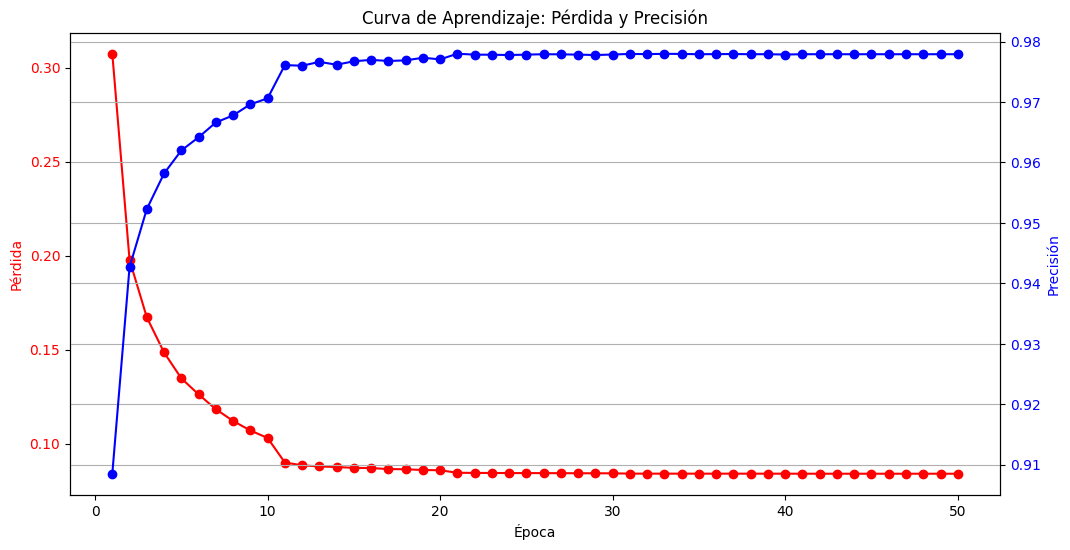

In [ ]:
import numpy as np
import struct

# Funciones para cargar imágenes y etiquetas
def load_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Cargar y preprocesar datos
train_images = load_images('/content/drive/MyDrive/Colab Notebooks/IC/train-images.idx3-ubyte')
train_labels = load_labels('/content/drive/MyDrive/Colab Notebooks/IC/train-labels.idx1-ubyte')
test_images = load_images('/content/drive/MyDrive/Colab Notebooks/IC/t10k-images.idx3-ubyte')
test_labels = load_labels('/content/drive/MyDrive/Colab Notebooks/IC/t10k-labels.idx1-ubyte')

# Normalizar y redimensionar imágenes
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape((-1, 1, 28, 28))
test_images = test_images.reshape((-1, 1, 28, 28))

# Función para convertir la imagen en columnas (im2col)
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return col

# Convolución utilizando im2col para optimizar
def conv_batch(input_images, filters, stride=1, padding=1):
    num_images, depth, height, width = input_images.shape
    num_filters, _, filter_height, filter_width = filters.shape
    out_height = (height + 2 * padding - filter_height) // stride + 1
    out_width = (width + 2 * padding - filter_width) // stride + 1

    # Convertir imágenes y filtros a formato columna
    col_images = im2col(input_images, filter_height, filter_width, stride, padding)
    col_filters = filters.reshape(num_filters, -1).T  # Convierte cada filtro en una fila
    output = np.dot(col_images, col_filters)
    output = output.reshape(num_images, out_height, out_width, -1).transpose(0, 3, 1, 2)
    return output

# Max Pooling utilizando im2col
def max_pool_batch(input_images, pool_size=2, stride=2):
    N, C, H, W = input_images.shape
    out_h = (H - pool_size) // stride + 1
    out_w = (W - pool_size) // stride + 1

    col = im2col(input_images, pool_size, pool_size, stride, pad=0)
    col = col.reshape(-1, pool_size * pool_size)
    out = np.max(col, axis=1)
    out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
    return out

# Inicialización de parámetros para la CNN
num_filters = 8
filter_size = 3
conv_filters = np.random.randn(num_filters, 1, filter_size, filter_size) * np.sqrt(2. / (1 * filter_size * filter_size))
output_height_after_conv = (28 + 2*1 - filter_size) // 1 + 1
pooled_height = output_height_after_conv // 2
dense_weights = np.random.randn(10, num_filters * pooled_height * pooled_height) * np.sqrt(2. / (num_filters * pooled_height * pooled_height))
dense_bias = np.zeros(10)

# Activación ReLU
def relu(x):
    return np.maximum(0, x)

# Decaimiento de tasa de aprendizaje exponencial
def adjust_learning_rate(initial_learning_rate, epoch, decay_rate=0.1):
    return initial_learning_rate * (0.1 ** (epoch // 10))

import matplotlib.pyplot as plt

# Modificar la función de entrenamiento para almacenar pérdida y precisión
def train_mini_batch_optimized(
    train_images, train_labels, test_images, test_labels, conv_filters, dense_weights, dense_bias,
    batch_size, epochs, initial_learning_rate
):
    num_samples = len(train_images)
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        # Ajuste de tasa de aprendizaje
        learning_rate = adjust_learning_rate(initial_learning_rate, epoch)

        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            batch_images = train_images[batch_indices]
            batch_labels = train_labels[batch_indices]

            # Propagación hacia adelante en lote
            conv_outs = conv_batch(batch_images, conv_filters)
            conv_outs = relu(conv_outs)
            pooled_outs = max_pool_batch(conv_outs)
            flat_outs = pooled_outs.reshape(batch_size, -1)

            # Capa densa y softmax
            logits = np.dot(flat_outs, dense_weights.T) + dense_bias
            softmax_outs = np.exp(logits - np.max(logits, axis=1, keepdims=True))
            softmax_outs /= np.sum(softmax_outs, axis=1, keepdims=True)

            # Cálculo de pérdida
            batch_loss = -np.log(softmax_outs[np.arange(batch_size), batch_labels]).mean()
            total_loss += batch_loss

            # Precisión en lote
            batch_predictions = np.argmax(softmax_outs, axis=1)
            correct_predictions += np.sum(batch_predictions == batch_labels)

            # Retropropagación
            d_out = softmax_outs
            d_out[np.arange(batch_size), batch_labels] -= 1
            d_out /= batch_size

            # Gradientes de capa densa
            dW_dense = np.dot(d_out.T, flat_outs)
            db_dense = d_out.sum(axis=0)

            # Actualización de pesos de la capa densa
            dense_weights -= learning_rate * dW_dense
            dense_bias -= learning_rate * db_dense

        avg_loss = total_loss / (num_samples // batch_size)
        train_accuracy = correct_predictions / num_samples
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(train_accuracy)
        print(f"CNN Época {epoch + 1}/{epochs} - Pérdida promedio: {avg_loss:.4f} - Precisión: {train_accuracy * 100:.2f}%")

    # Evaluar precisión en el conjunto de prueba
    test_accuracy = evaluate_cnn(test_images, test_labels, conv_filters, dense_weights, dense_bias)
    print(f"Precisión en el conjunto de prueba: {test_accuracy * 100:.2f}%")

    return conv_filters, dense_weights, dense_bias, epoch_losses, epoch_accuracies, test_accuracy

# Evaluar la CNN
def evaluate_cnn(test_images, test_labels, conv_filters, dense_weights, dense_bias):
    num_samples = len(test_images)
    correct_predictions = 0

    for i in range(num_samples):
        image = test_images[i:i + 1]
        label = test_labels[i]

        # Propagación hacia adelante
        conv_outs = conv_batch(image, conv_filters)
        conv_outs = relu(conv_outs)
        pooled_outs = max_pool_batch(conv_outs)
        flat_outs = pooled_outs.reshape(1, -1)

        logits = np.dot(flat_outs, dense_weights.T) + dense_bias
        softmax_outs = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        softmax_outs /= np.sum(softmax_outs, axis=1, keepdims=True)

        prediction = np.argmax(softmax_outs)
        if prediction == label:
            correct_predictions += 1

    return correct_predictions / num_samples

# Entrenar la Red Neuronal Convolutiva y obtener las métricas
batch_size = 32
epochs_cnn = 50
initial_learning_rate = 0.1
conv_filters, dense_weights, dense_bias, epoch_losses, epoch_accuracies, test_accuracy = train_mini_batch_optimized(
    train_images, train_labels, test_images, test_labels, conv_filters, dense_weights, dense_bias, batch_size, epochs_cnn, initial_learning_rate
)

# Graficar la curva de pérdida y precisión
plt.figure(figsize=(12, 6))

# Eje izquierdo: Pérdida
plt.plot(range(1, epochs_cnn + 1), epoch_losses, marker='o', label='Pérdida', color='red')
plt.ylabel('Pérdida', color='red')
plt.xlabel('Época')
plt.tick_params(axis='y', labelcolor='red')

# Eje derecho: Precisión
ax2 = plt.gca().twinx()
ax2.plot(range(1, epochs_cnn + 1), epoch_accuracies, marker='o', label='Precisión', color='blue')
ax2.set_ylabel('Precisión', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Títulos y leyendas
plt.title('Curva de Aprendizaje: Pérdida y Precisión')
plt.grid(True)
plt.show()